In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import yfinance as yf


In [28]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [29]:
# ---------------------------------------------------------
# 1. DATEN LADE & VORBEREITUNG
# ---------------------------------------------------------
# Definiere dein Universum (Liste der Ticker)
tickers = ["NVDA", "TSLA", "ASML", "META", "AMZN", "SPY"]

# Daten laden (letzte 2 Jahre für solide Korrelation)
data = yf.download(tickers, period="2y", interval="1d")['Close']

# Berechne tägliche Returns (Log-Returns sind oft besser, aber pct_change reicht hier)
returns = data.pct_change().dropna()

print("Daten geladen. Shape der Returns:", returns.shape)

C:\Users\Besitzer\AppData\Local\Temp\ipykernel_22824\2559472686.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="2y", interval="1d")['Close']
[*********************100%***********************]  6 of 6 completed

Daten geladen. Shape der Returns: (501, 6)


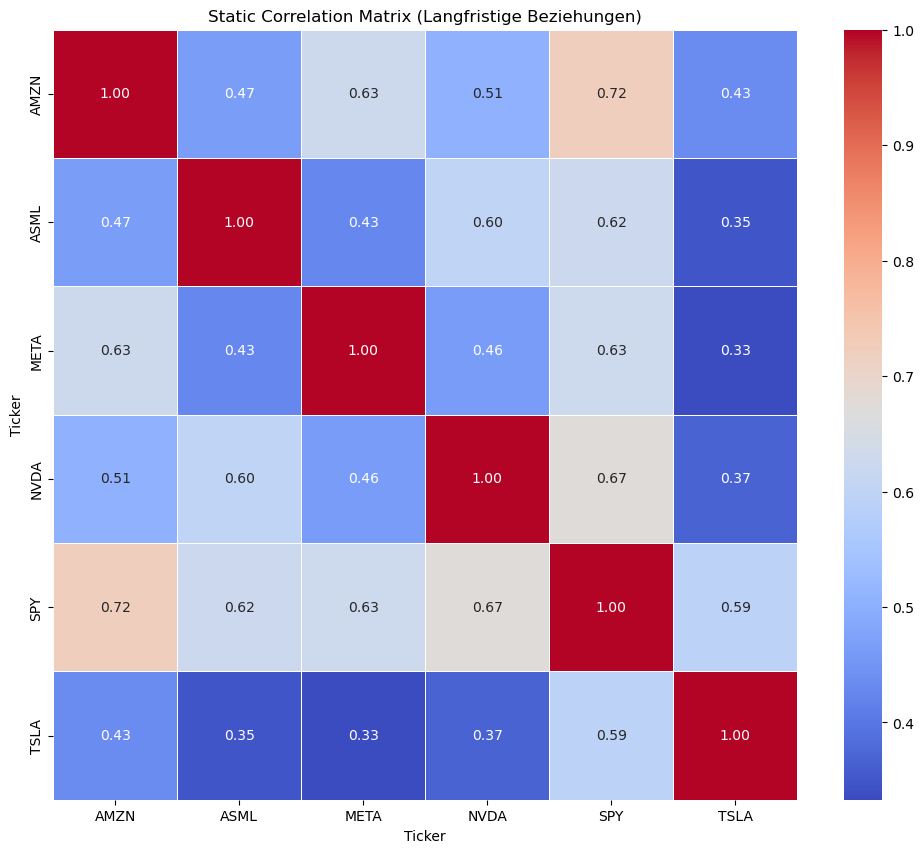

In [30]:
# ---------------------------------------------------------
# 2. STATIC CORRELATION MATRIX (Das Fundament)
# ---------------------------------------------------------
# Berechne die Korrelation über den gesamten Zeitraum
static_corr_matrix = returns.corr()

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(static_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Static Correlation Matrix (Langfristige Beziehungen)")
plt.show()

In [31]:
# ---------------------------------------------------------
# 3. K-MEANS CLUSTERING (Sektoren neu definieren)
# ---------------------------------------------------------
# Wir nutzen die transponierten Returns oder die Korrelationsmatrix als Feature
# Hier nutzen wir die Korrelationsmatrix als "Abstand", um ähnliche Assets zu finden
X = static_corr_matrix.values

# Anzahl der Cluster bestimmen (z.B. 3: Tech/Growth, Defensive, Market)
k = 3 
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X)

# Ergebnisse speichern
cluster_map = pd.DataFrame({'Ticker': tickers, 'Cluster': kmeans.labels_})
print("\n--- Gefundene Cluster ---")
print(cluster_map.sort_values(by='Cluster'))

c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- Gefundene Cluster ---
  Ticker  Cluster
5    SPY        0
0   NVDA        1
2   ASML        1
4   AMZN        1
1   TSLA        2
3   META        2


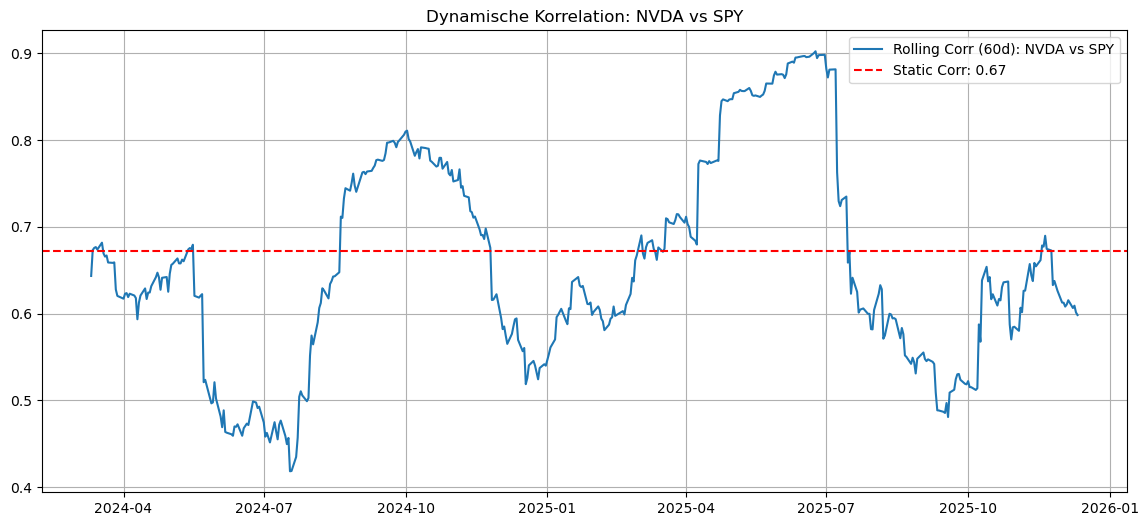


--- Analyse für NVDA ---
Statische Korrelation: 0.67
Aktuelle Rolling Korrelation: 0.60
Delta: -0.07
✅ STATUS: Verhalten im normalen Bereich.


In [32]:
# ---------------------------------------------------------
# 4. ROLLING CORRELATION (Dynamik & Anomalien)
# ---------------------------------------------------------
# Beispiel: Wir vergleichen NVDA mit dem Markt (META)
target_stock = 'NVDA'
benchmark = 'SPY'
window_size = 60 # 60 Handelstage = ca. 1 Quartal

# Berechne Rolling Correlation
rolling_corr = returns[target_stock].rolling(window=window_size).corr(returns[benchmark])

# Berechne Static Correlation als Referenzlinie
static_val = returns[target_stock].corr(returns[benchmark])

# Visualisierung
plt.figure(figsize=(14, 6))
plt.plot(rolling_corr.index, rolling_corr, label=f'Rolling Corr (60d): {target_stock} vs {benchmark}')
plt.axhline(static_val, color='red', linestyle='--', label=f'Static Corr: {static_val:.2f}')
plt.title(f"Dynamische Korrelation: {target_stock} vs {benchmark}")
plt.legend()
plt.grid(True)
plt.show()

# Interpretation für den Agenten:
current_rolling = rolling_corr.iloc[-1]
corr_delta = current_rolling - static_val
print(f"\n--- Analyse für {target_stock} ---")
print(f"Statische Korrelation: {static_val:.2f}")
print(f"Aktuelle Rolling Korrelation: {current_rolling:.2f}")
print(f"Delta: {corr_delta:.2f}")

if abs(corr_delta) > 0.2:
    print("⚠️ WARNUNG: Signifikante Abweichung vom historischen Mittel! (Regime Change möglich)")
else:
    print("✅ STATUS: Verhalten im normalen Bereich.")

In [33]:
# ---------------------------------------------------------
# 5. OPPORTUNITY SCORE BERECHNUNG
# ---------------------------------------------------------
def calculate_opportunity_score(ticker, cluster_df, chart_score, news_score, rolling_delta):
    """
    Berechnet den finalen Score basierend auf deiner Logik.
    
    W1 * C_tech + W2 * N_senti + W3 * K_corr
    """
    # Gewichte (kannst du anpassen)
    W1 = 0.4 # Chart hat hohes Gewicht
    W2 = 0.3 # News
    W3 = 0.3 # Korrelation/Cluster Kontext
    
    # K_corr Logik:
    # Wenn Rolling Corr stark fällt (Aktie entkoppelt sich positiv) -> Bonus
    # Wenn Cluster 'schwach' ist, aber Aktie 'stark' -> Malus (Vorsicht)
    # Hier vereinfacht: Wir nutzen das Delta als Faktor
    
    k_corr_score = 0
    if rolling_delta < -0.1: 
        k_corr_score = 0.5 # Entkopplung (Eigenleben) kann gut sein
    elif rolling_delta > 0.2:
        k_corr_score = -0.5 # Zu hohe Abhängigkeit vom Markt (Risiko)
        
    # Finaler Score
    score = (W1 * chart_score) + (W2 * news_score) + (W3 * k_corr_score)
    return score

# Beispiel-Aufruf für NVDA
# Angenommen: Chart ist bullish (1.0), News sind neutral (0.0)
opp_score = calculate_opportunity_score('NVDA', cluster_map, chart_score=1.0, news_score=0.0, rolling_delta=corr_delta)

print(f"\n--- Finaler Opportunity Score für NVDA ---")
print(f"Score: {opp_score:.2f} (Skala ca. -1 bis +1)")


--- Finaler Opportunity Score für NVDA ---
Score: 0.40 (Skala ca. -1 bis +1)
